# Gait classification

## Libraries and directory

In [49]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'



In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = '/content/drive/MyDrive/Human_Data/Progetto'
    # root_directory = '/content/drive/MyDrive/Progetto'
    # root_directory = '/content/drive/MyDrive/Progetto'

print('root directory is ' + root_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition


## Train/Test Split


In [51]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv(root_directory+'/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]
reference_df['Label'] = reference_df['Label'].astype(int)

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0
...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2


In [52]:
def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)
reference_df.set_index('Complete_path', inplace=True)
reference_df = reference_df.drop(columns=['Path_from_Root'])
reference_df

,Name_file,Type_of_data,Type_of_gait,Label
Complete_path,,,,
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_S.csv,Sbj9_antalgic_T2_S.csv,skeleton,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,pressure,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_S.csv,Sbj9_antalgic_T8_S.csv,skeleton,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,pressure,antalgic,0
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,pressure,antalgic,0
...,...,...,...,...
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject8/normal/trial17/Sbj8_normal_T17_S.csv,Sbj8_normal_T17_S.csv,skeleton,normal,2
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject8/normal/trial10/Sbj8_normal_T10_P.csv,Sbj8_normal_T10_P.csv,pressure,normal,2
/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition/dataset/subject8/normal/trial10/Sbj8_normal_T10_S.csv,Sbj8_normal_T10_S.csv,skeleton,normal,2


In [53]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

#split the dataframe into skeleton and pressure, drop the type column

reference_df_s = reference_df[reference_df['Type_of_data']=='skeleton']
reference_df_s = reference_df_s.drop(columns=['Type_of_data', 'Type_of_gait'])

reference_df_p = reference_df[reference_df['Type_of_data']=='pressure']
reference_df_p = reference_df_p.drop(columns=['Type_of_data', 'Type_of_gait'])


# We want to split the data using 11 subjects as training set and 1 subject as test set
# In this way we are sure that train and test are completely dinstinct

# train_test split
train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith('Sbj12')]
val_s = reference_df_s[reference_df_s['Name_file'].str.startswith('Sbj12')]

train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith('Sbj12')]
val_p = reference_df_p[reference_df_p['Name_file'].str.startswith('Sbj12')]

train_s = train_s.drop(columns=['Name_file'])
val_s = val_s.drop(columns=['Name_file'])
train_p = train_p.drop(columns=['Name_file'])
val_p = val_p.drop(columns=['Name_file'])


#frequence counts
print("Train Skelly")
print(train_s['Label'].value_counts())
print('\n',"Validation Skelly")
print(val_s['Label'].value_counts())
print('\n',"Train Pressure")
print(train_p['Label'].value_counts())
print('\n',"Validation Pressure")
print(val_p['Label'].value_counts())

Train Skelly
0    220
4    220
5    220
3    220
2    220
1    220
Name: Label, dtype: int64

 Validation Skelly
5    20
4    20
0    20
3    20
2    20
1    20
Name: Label, dtype: int64

 Train Pressure
0    220
4    220
5    220
3    220
2    220
1    220
Name: Label, dtype: int64

 Validation Pressure
5    20
4    20
0    20
3    20
2    20
1    20
Name: Label, dtype: int64


## Skeletron: load and preprocessing

### Defenition of the load function

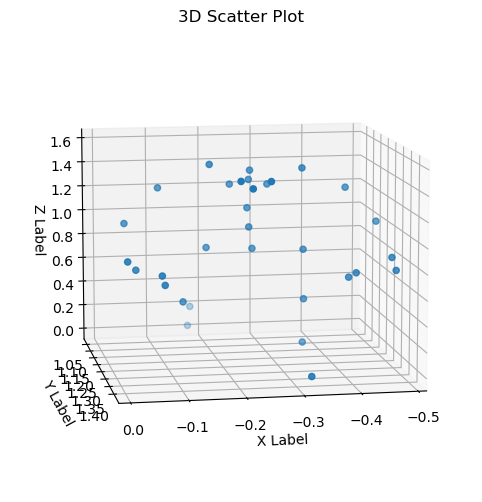

In [54]:
def load_data_sk(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  df_skelly = pd.read_csv(complete_path, header=None)
  df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

  #convert to np array and reshape
  data = df_skelly.to_numpy().reshape((-1,32,3))

  return data.squeeze()


# Example
sk_data = load_data_sk(train_s.index[1], load=False)

#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

### Defenition of the normalization function

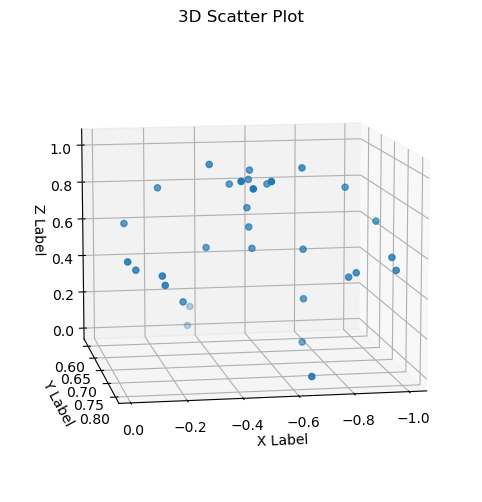

In [55]:
def normalize_data_sk(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = data[:, :, 0] / norm_factor_x
    data[:, :, 1] = data[:, :, 1] / norm_factor_y
    data[:, :, 2] = data[:, :, 2] / norm_factor_z

    return data


# Example
sk_data = load_data_sk(train_s.index[1], load=False)
sk_data_norm = normalize_data_sk(sk_data)


#plot example, select only one frame
plotdata = sk_data[150]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

Perche' all'inizio veloce e poi lenta?

In [56]:
# # check duration of walking samples
# hist = []

# c = 0

# for i in reference_df_s.index:
#     data = load_data_sk(i, reference_df_s)
#     hist.append(data.shape[0])

#     if c % 100 == 0:
#       print('Step:', c)
#     c += 1

# # Create a histogram
# plt.hist(hist, bins=150, edgecolor='black')

# # Add a vertical line for the median
# plt.axvline(np.median(hist), color='red', linestyle='dashed', linewidth=1)
# plt.axvline(np.mean(hist), color='yellow', linestyle='dashed', linewidth=1)

# # Add labels and title
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram')

# # Show the plot
# plt.show()
# print("Median of data (red)",np.median(hist))
# print("Mean of data (yellow)",np.mean(hist))
# print("Standard dev of data", np.std(hist))

### Defenition of the crop function

In [57]:
def random_crop(data, target_size=50, noise_time=20, center_crop=False):

  # remove initial and final frames that we consider as noise
  start = noise_time
  end = data.shape[0] - noise_time

  data = data[start:end, :]

  N = data.shape[0]

  # Random Crop (always centered if center_crop=True)
  if center_crop:
      from_ = int((N / 2) - (target_size / 2))
      # print('Start of the crop: ', from_)
  else:
      from_ = np.random.randint(0, np.floor(N - target_size))
      # print('Start of the crop: ', from_)

  return data[from_:from_ + target_size]


# Example
sk_data = load_data_sk(train_s.index[1], load=False)

sk_data_crop = random_crop(sk_data)
print('Original shape ', sk_data.shape, 'Cropped/Padded shape ', sk_data_crop.shape)

Original shape  (207, 32, 3) Cropped/Padded shape  (50, 32, 3)


### Unique load_preprocessing function

In [58]:
def load_prep_sk(complete_path):
    data = load_data_sk(complete_path, load=True)
    data = normalize_data_sk(data)

    # riportati i dati in un vettore pronti per il RNN
    data = data.reshape(data.shape[0], -1)

    return data.astype(np.float32)

## Skeletron dataset

### Classifier

#### Defenition of the function to create the dataset

In [12]:
def create_dataset_sk(table, cache_file, shuffle, batch_size, target_size=50, noise_time=20, center_crop=False):

  # shape
  input_size = (target_size, 96)

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_sk, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, noise_time, center_crop], tf.float32),
                                              input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

#### Dataset inizialization

In [13]:
batch_s = 30

dataset_train_s = create_dataset_sk(table = train_s,
                                    cache_file = 'train_s_cache',
                                    shuffle = True,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

dataset_val_s = create_dataset_sk(table = val_s,
                                    cache_file = 'val_s_cache',
                                    shuffle = False,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

train_steps_s = int(np.ceil(len(train_s)/batch_s))
val_steps_s = int(np.ceil(len(val_s)/batch_s))

### Autoencoders

#### Defenition of the function to create the dataset

In [59]:
def create_dataset_autoencoders_sk(table, cache_file, shuffle, batch_size, target_size=50, noise_time=20, center_crop=False):

  # shape
  input_size = (target_size, 96)

  # Convert dataframe to lists
  file_names = list(table.index)

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path: (tf.numpy_function(load_prep_sk, [path], tf.float32))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, noise_time, center_crop], tf.float32), input_size))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # After the cache to be sure that they have the same data
  # Duplicate data for the autoencoder (input = output)
  py_funct = lambda data: (data, data)
  dataset = dataset.map(py_funct)

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

#### Dataset inizialization

In [60]:
batch_s = 30

dataset_train_s_autoencoder = create_dataset_autoencoders_sk(table = train_s,
                                    cache_file = 'train_s_cache_autoencoder',
                                    shuffle = True,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)

dataset_val_s_autoencoder = create_dataset_autoencoders_sk(table = val_s,
                                    cache_file = 'val_s_cache_autoencoder',
                                    shuffle = False,
                                    batch_size = batch_s,
                                    target_size = 50,
                                    noise_time = 20,
                                    center_crop = False)


train_steps_s = int(np.ceil(len(train_s)/batch_s))
val_steps_s = int(np.ceil(len(val_s)/batch_s))

first_element_dataset_k = dataset_train_s_autoencoder.take(1)
first_element_dataset_k

for d, l in first_element_dataset_k:
  print(d.numpy().shape, l.numpy().shape)
  print(np.array_equal(d.numpy(), l.numpy()))

(30, 50, 96) (30, 50, 96)
True


2024-02-14 12:11:52.410500: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Pressure: load and preprocessing

### Defenition of the load function

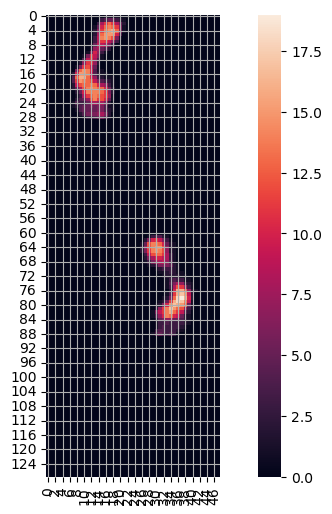

In [10]:
def load_data_ps(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

  return pressure_data.squeeze()


# Example
ps_data = load_data_ps(train_p.index[330], load=False)

sns.heatmap(ps_data, square= True)
plt.show()

### Defenition of the normalization function

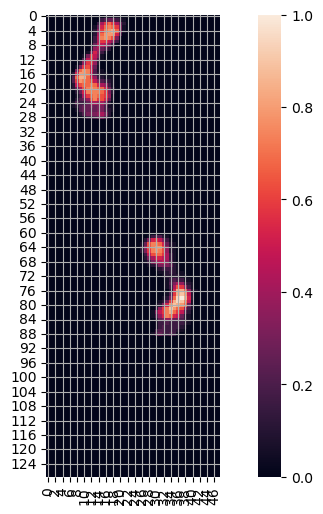

In [11]:
def normalize_data_ps(data):
    massimo = np.max(data)
    data = data / massimo
    return data

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)

sns.heatmap(ps_data_norm, square= True)
plt.show()

### Defenition of the centering function

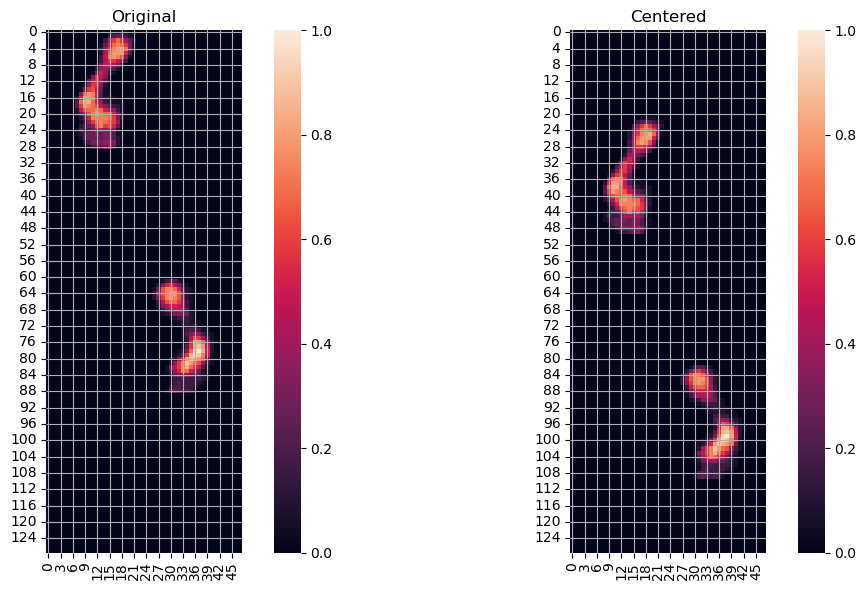

In [12]:
def baricenter(data):
  # Compute the weighted average (barycenter) along each dimension
  y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
  x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

  # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
  # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

  # Compute the distances between each point and the barycenter
  shift_x = -(x_barycenter - data.shape[1]/2)
  shift_y = -(y_barycenter - data.shape[0]/2)

  # Shift the foot pressure matrix to be centered on the barycenter
  shifted_matrix = np.roll(data, int(shift_x), axis=1)
  shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

  # y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
  # x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
  # print("Barycenter coordinates (x,y) afetr= ", x_barycenter_after, y_barycenter_after, '\n')

  return shifted_matrix

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)
cen_ps_data_norm = baricenter(ps_data_norm)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')

# Plot the second heatmap
sns.heatmap(cen_ps_data_norm, square=True,ax=axes[1])
axes[1].set_title('Centered')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Unique load_preprocessing function

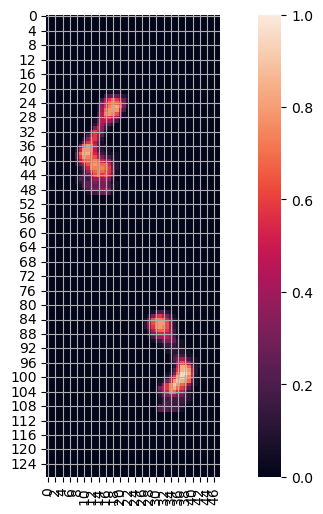

In [14]:
def load_prep_ps(complete_path, load=True):
    data = load_data_ps(complete_path, load)
    data = normalize_data_ps(data)
    data = baricenter(data)

    return data.astype(np.float32)



 # to try you have to set load=False
ps_data_end = load_prep_ps(train_p.index[330], load=False)

 # Plot the first heatmap
sns.heatmap(ps_data_end, square=True)
plt.show()

## Pressure dataset

### Classifier

#### Defenition of the function to create the dataset

In [15]:
def create_dataset_ps(table, cache_file, shuffle, batch_size):

  # Convert dataframe to lists
  file_names = list(table.index)
  labels = file_names

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_ps, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img, label: (tf.expand_dims(img, 2), label))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

#### Dataset inizialization

In [16]:
batch_p = 20

dataset_train_p = create_dataset_ps(table = train_p,
                                    cache_file = 'train_p_cache',
                                    shuffle = True,
                                    batch_size = batch_p)

dataset_val_p = create_dataset_ps(table = val_p,
                                    cache_file = 'val_p_cache',
                                    shuffle = False,
                                    batch_size = batch_p)

train_steps_p = int(np.ceil(len(train_p)/batch_p))
val_steps_p = int(np.ceil(len(val_p)/batch_p))

2024-02-14 10:49:09.437482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Autoencoders

#### Defenition of the function to create the dataset

In [17]:
def create_dataset_autoencoder_ps(table, cache_file, shuffle, batch_size, ):

  # Convert dataframe to lists
  file_names = list(table.index)

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names))

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the load_and_preprocess_data function
  py_func = lambda path: (tf.numpy_function(load_prep_ps, [path], tf.float32))
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Duplicate data for the autoencoder (input = output)
  py_funct = lambda img: (img, img)
  dataset = dataset.map(py_funct)

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img_1, img_2: (tf.expand_dims(img_1, 2), (tf.expand_dims(img_2, 2))))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

#### Dataset inizialization

In [18]:
batch_p = 20

dataset_train_p_autoencoder = create_dataset_autoencoder_ps(table = train_p,
                                    cache_file = 'train_p_cache_autoencoder',
                                    shuffle = True,
                                    batch_size = batch_p)

dataset_val_p_autoencoder = create_dataset_autoencoder_ps(table = val_p,
                                    cache_file = 'val_p_cache_autoencoder',
                                    shuffle = False,
                                    batch_size = batch_p)

train_steps_p = int(np.ceil(len(train_p)/batch_p))
val_steps_p = int(np.ceil(len(val_p)/batch_p))

# first_element_dataset_p = dataset_train_p_autoencoder.take(1)
# first_element_dataset_p

# for d, l in first_element_dataset_p:
#   d_0 = d.numpy()
#   l_0 = l.numpy()
#   print(d.numpy().shape)
#   print(l.numpy().shape)
#   print(np.array_equal(d_0, l_0))

## RNN autoencoders

In [61]:
def RNN_autoencoder(time_length, latent_dim, code_size):

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input((time_length, 96)))

    encoder.add(tf.keras.layers.GRU(latent_dim, return_sequences=True, activation='tanh', name='I_GRU'))
    encoder.add(tf.keras.layers.GRU(latent_dim, return_sequences=True, activation='tanh', name='II_GRU'))

    encoder.add(tf.keras.layers.GRU(latent_dim, return_sequences=True, activation='tanh', name='III_GRU'))
    encoder.add(tf.keras.layers.GRU(code_size, return_sequences=False, activation='tanh', name='IV_GRU'))

    # encoder.add(tf.keras.layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(tf.keras.layers.RepeatVector(time_length))
    decoder.add(tf.keras.layers.GRU(96, return_sequences=True, activation='tanh', name='decoder_GRU'))

    return encoder, decoder


encoder_rnn, decoder_rnn = RNN_autoencoder(time_length=50, latent_dim=225, code_size=125)
print(encoder_rnn.output_shape[1:])
print(decoder_rnn.output_shape[1:])
encoder_rnn.summary()
decoder_rnn.summary()

(125,)
(50, 96)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 I_GRU (GRU)                 (None, 50, 225)           218025    
                                                                 
 II_GRU (GRU)                (None, 50, 225)           305100    
                                                                 
 III_GRU (GRU)               (None, 50, 225)           305100    
                                                                 
 IV_GRU (GRU)                (None, 125)               132000    
                                                                 
Total params: 960,225
Trainable params: 960,225
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_

In [62]:
inp_seq = tf.keras.Input((50, 96))
code_rnn = encoder_rnn(inp_seq)
reconstruction_seq = decoder_rnn(code_rnn)

autoencoder_rnn = tf.keras.Model(inputs=inp_seq, outputs=reconstruction_seq)

autoencoder_rnn.compile(optimizer="adamax", loss='mse')

In [63]:
# Train the model
num_epochs = 100

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

autoencoder_rnn.fit(dataset_train_s_autoencoder,
                epochs=num_epochs,
                steps_per_epoch=train_steps_s,
                validation_data=dataset_val_s_autoencoder,
                validation_steps=val_steps_s,
                callbacks=[early_stop_callback])


path_encoder_RNN = root_directory + '/encoder_RNN.h5'
path_decoder_RNN = root_directory + '/decoder_RNN.h5'

encoder_rnn.save(path_encoder_RNN)
decoder_rnn.save(path_decoder_RNN)

Epoch 1/100
43/44 [============================>.] - ETA: 0s - loss: 0.0485

2024-02-14 12:12:34.941531: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


44/44 [==============================] - 15s 249ms/step - loss: 0.0476 - val_loss: 0.0085
Epoch 2/100


2024-02-14 12:12:36.643672: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


44/44 [==============================] - 7s 163ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 3/100
44/44 [==============================] - 7s 163ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 4/100
44/44 [==============================] - 7s 164ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 5/100
44/44 [==============================] - 7s 166ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 6/100
44/44 [==============================] - 8s 185ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 7/100
44/44 [==============================] - 8s 180ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 8/100
44/44 [==============================] - 8s 173ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 9/100
44/44 [==============================] - 8s 180ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 10/100
44/44 [==============================] - 8s 178ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 11/100
44/44 [==============================] - 8s 182ms/step - loss: 0.0055 - val_loss: 0.0039


In [65]:
path_encoder_RNN = root_directory + '/encoder_RNN.h5'
path_decoder_RNN = root_directory + '/decoder_RNN.h5'

encoder_rnn_load = keras.models.load_model(path_encoder_RNN)
decoder_rnn_load = keras.models.load_model(path_decoder_RNN)

1/1 [==============================] - 1s 830ms/step
(1, 125)
1/1 [==============================] - 0s 206ms/step


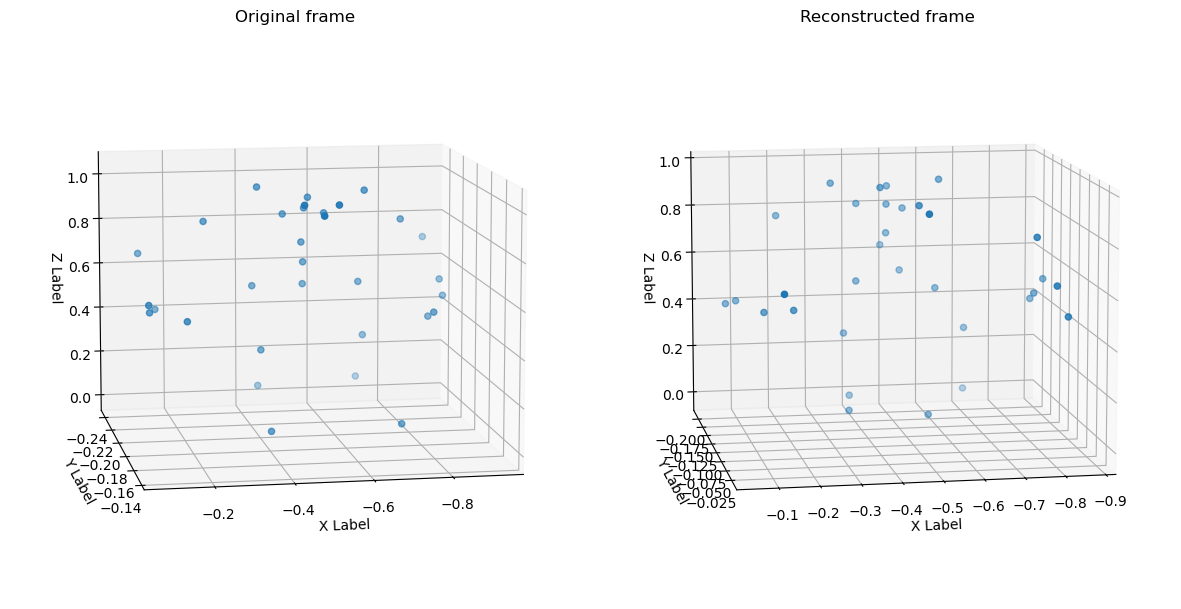

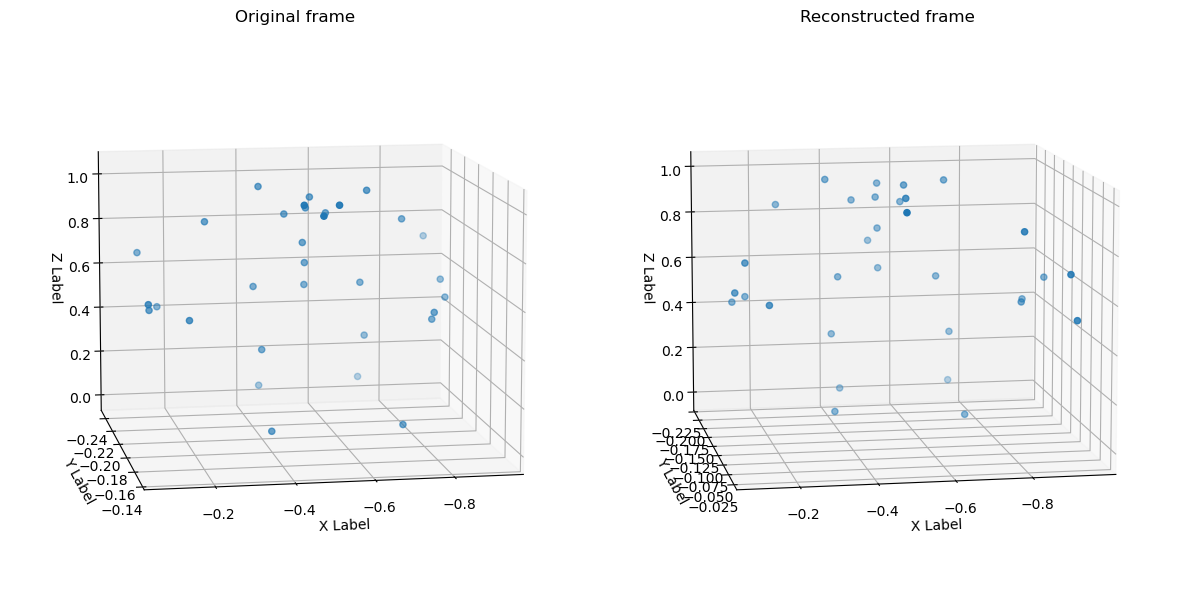

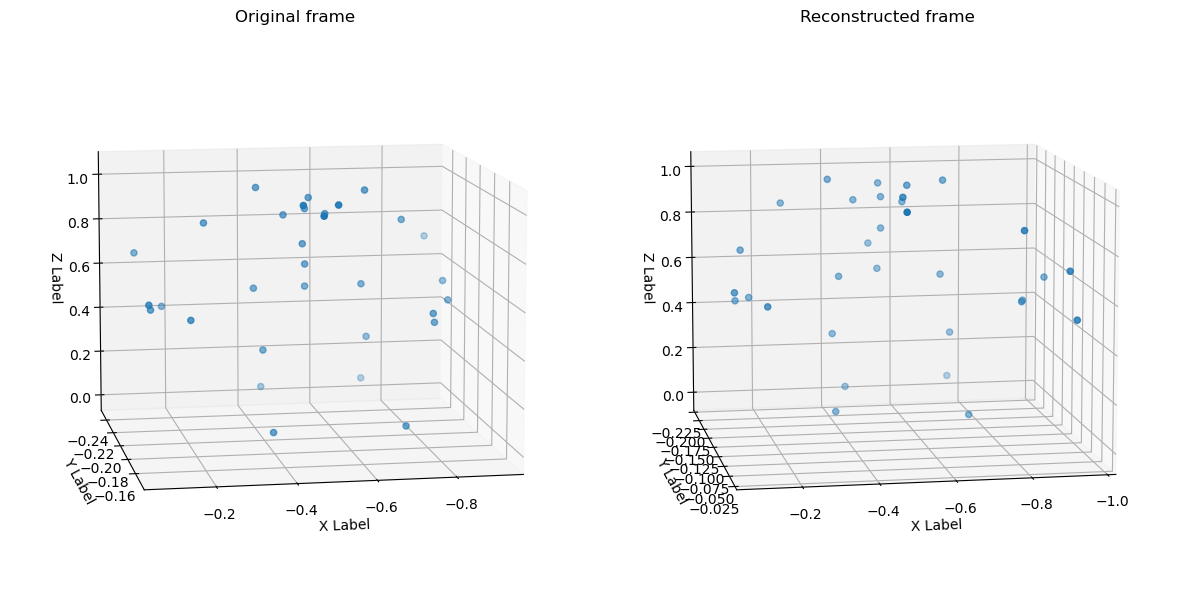

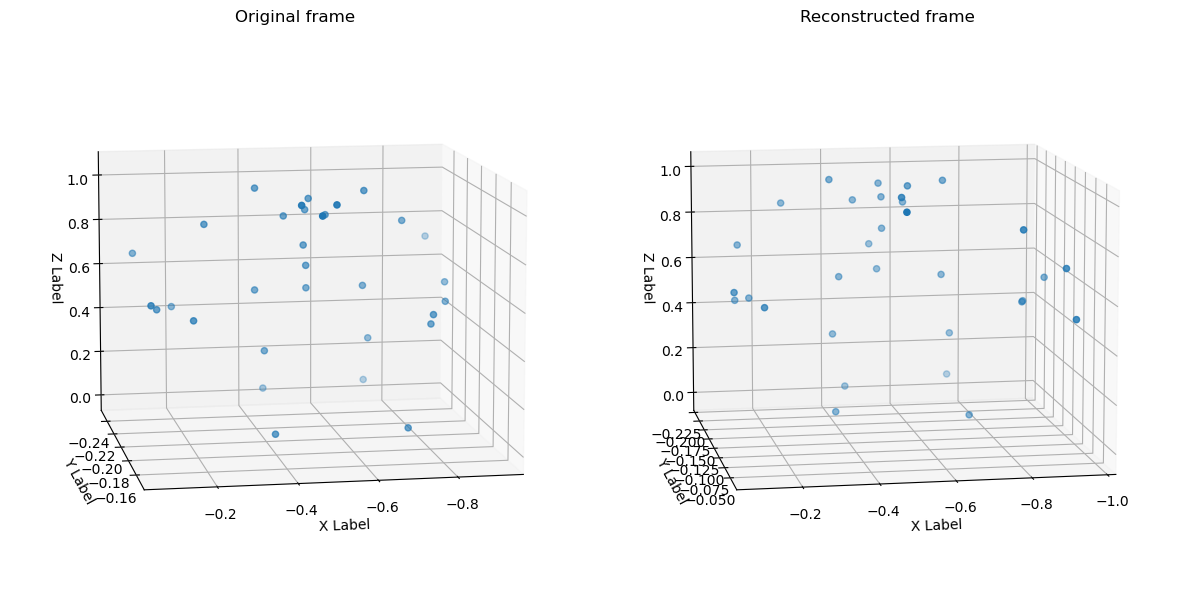

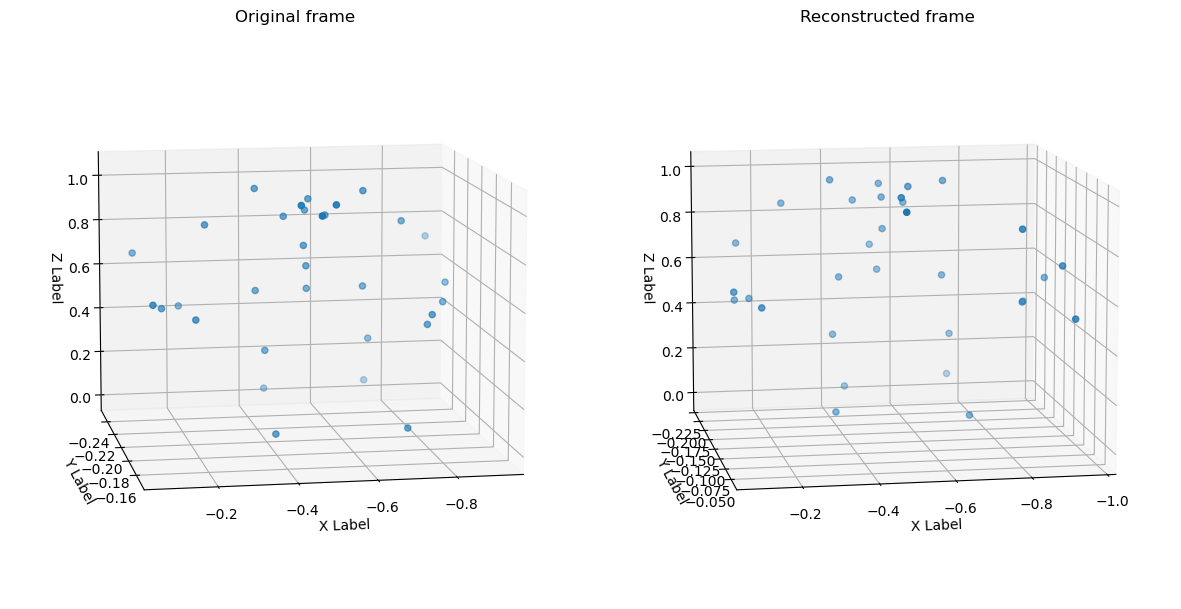

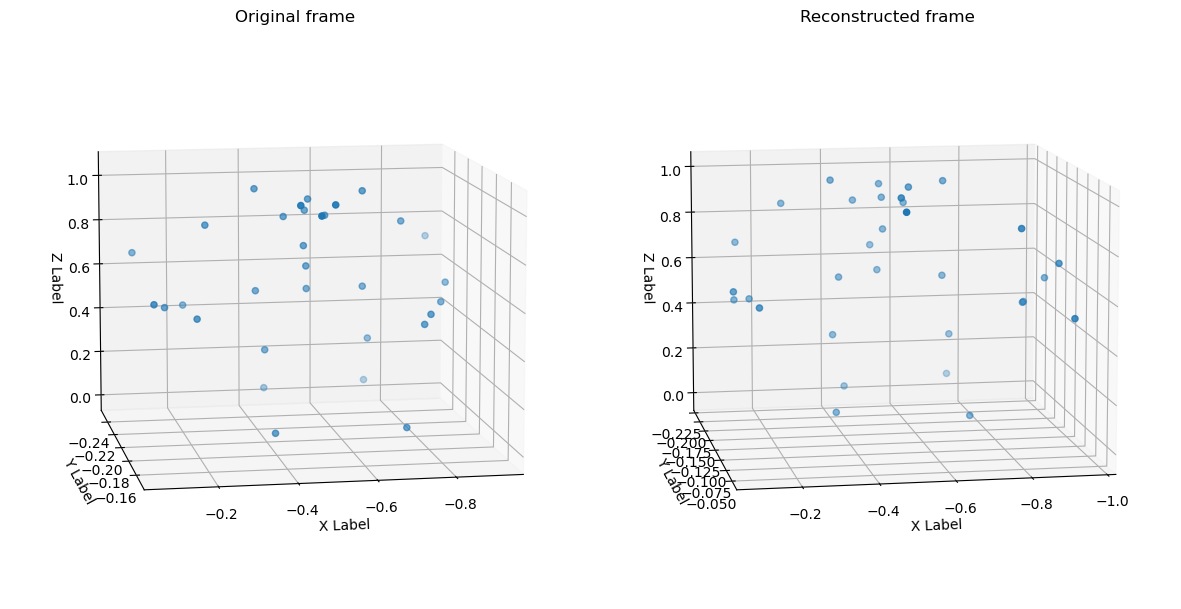

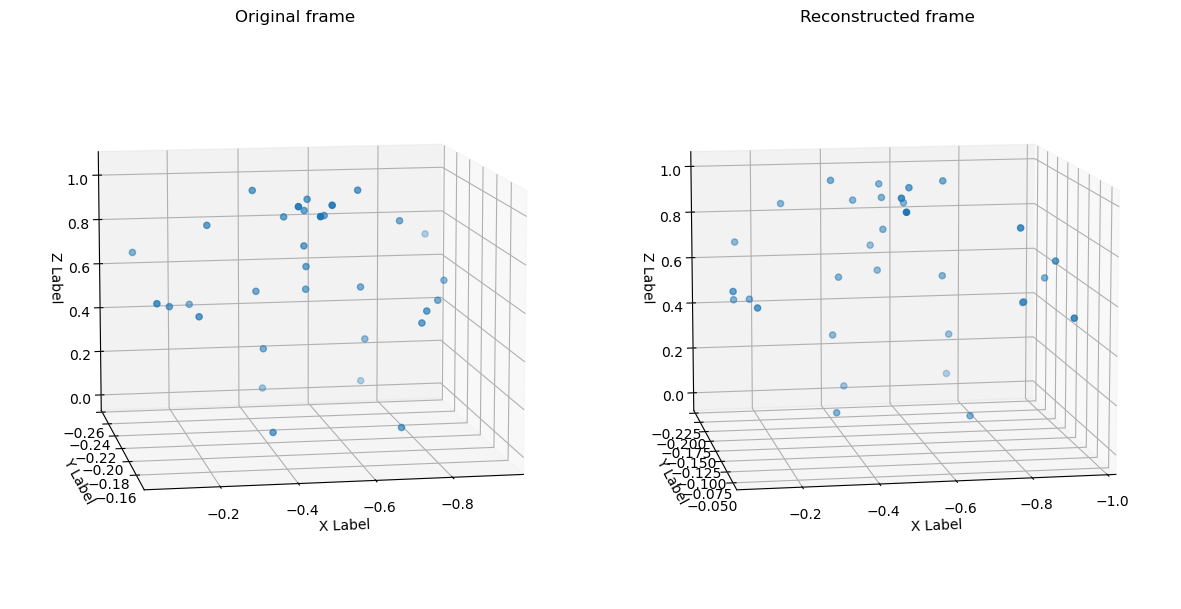

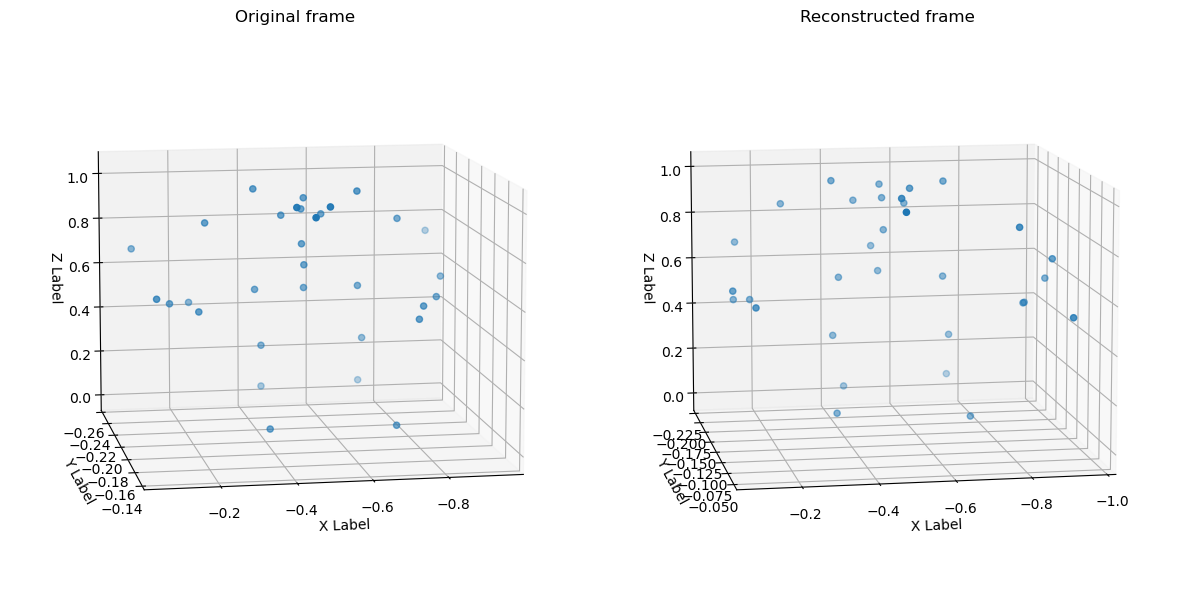

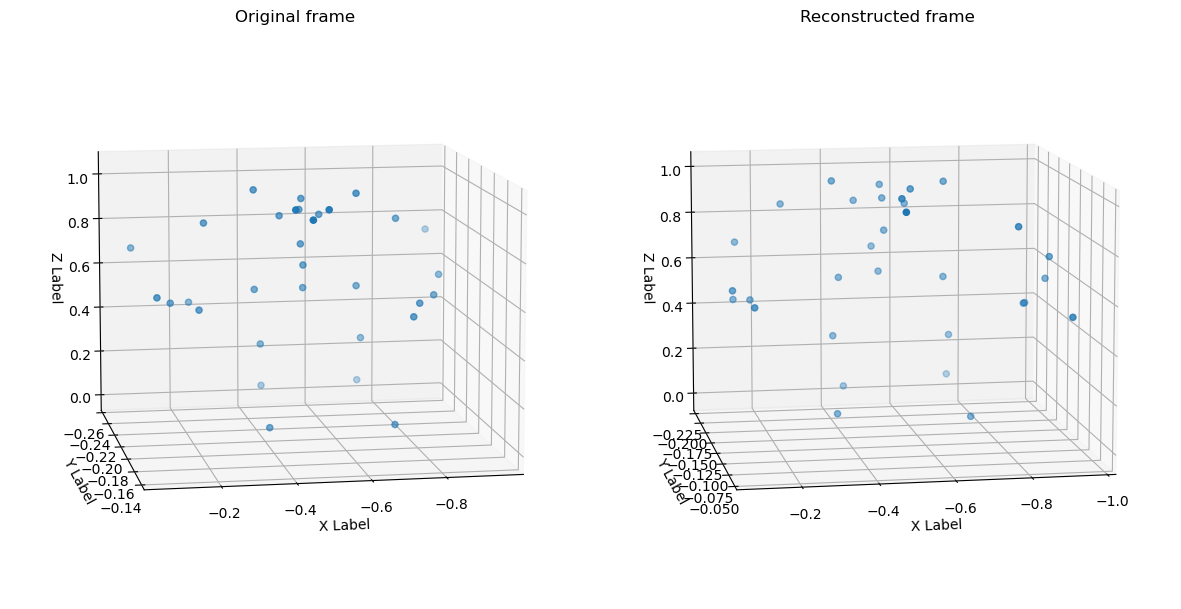

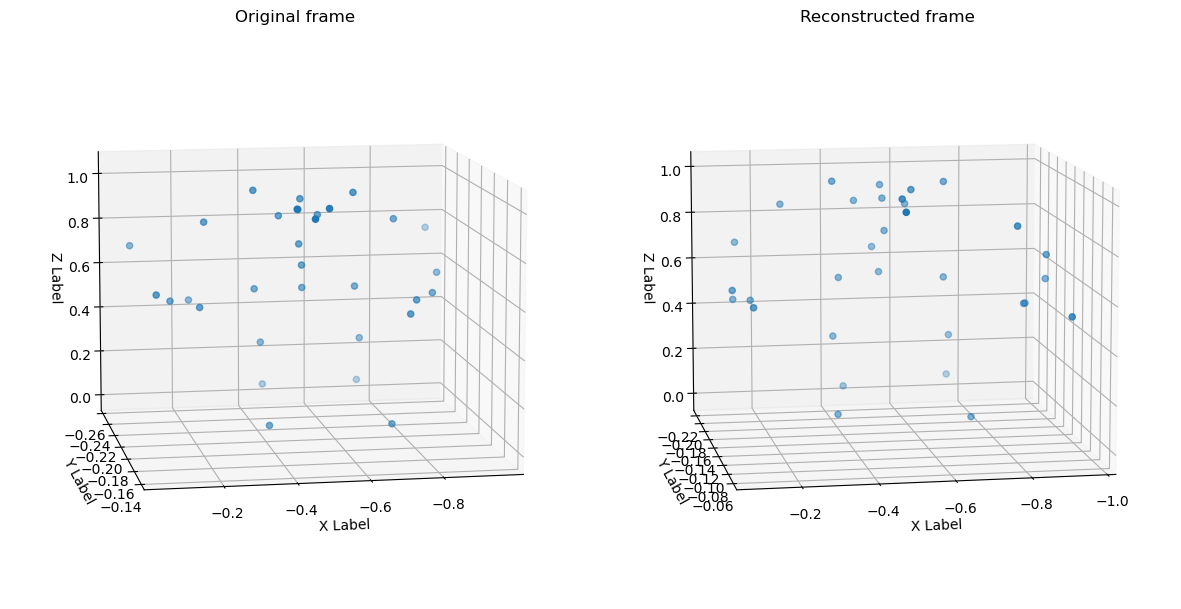

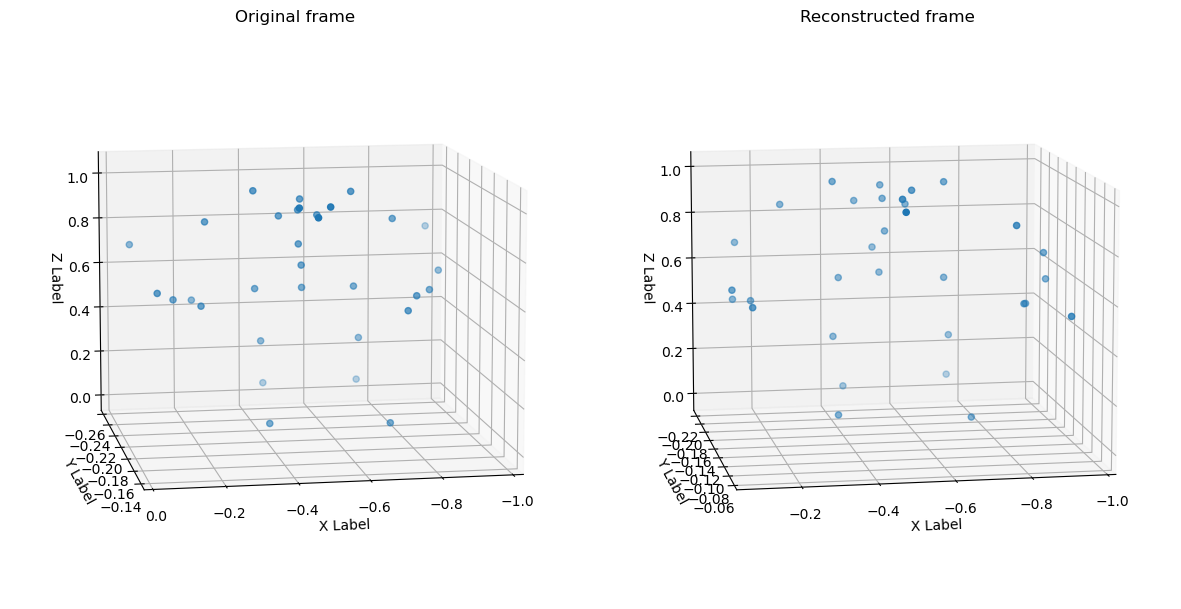

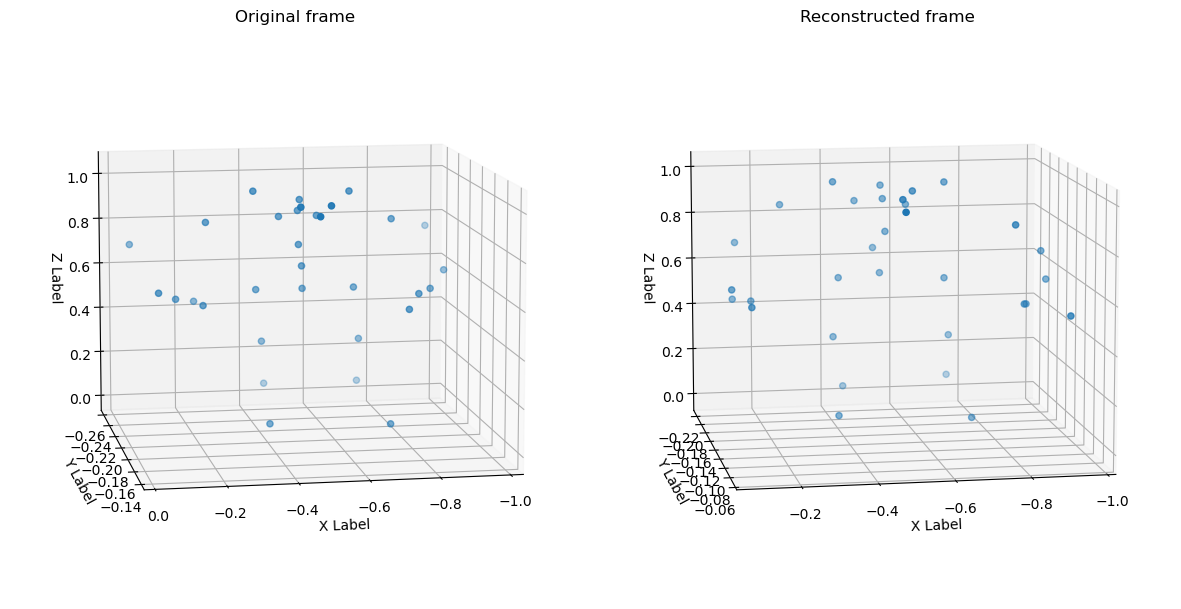

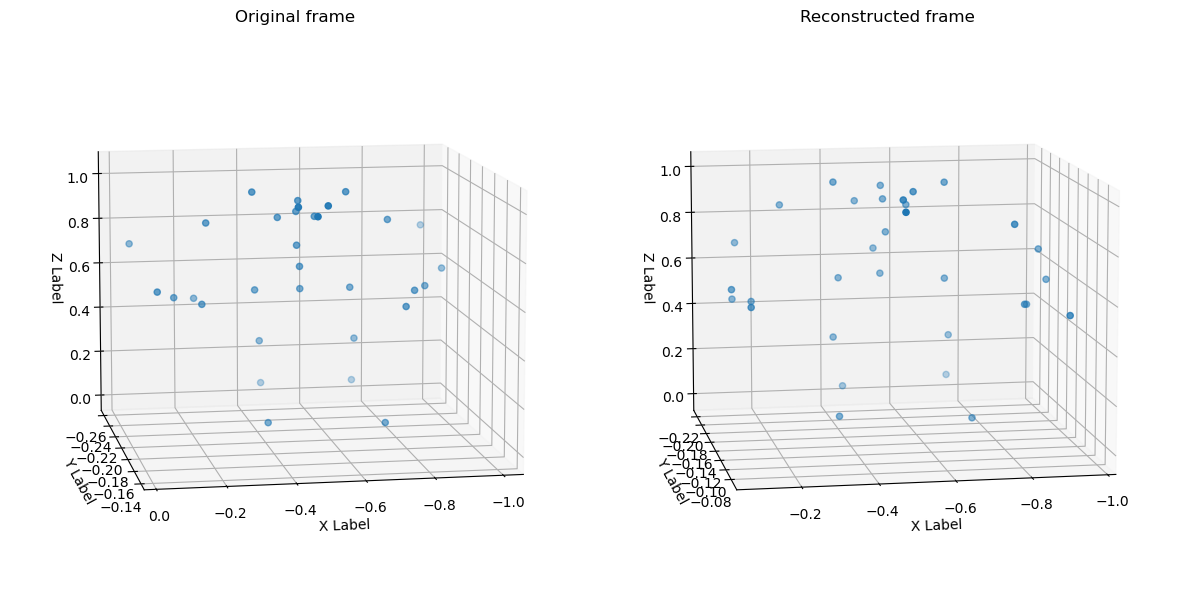

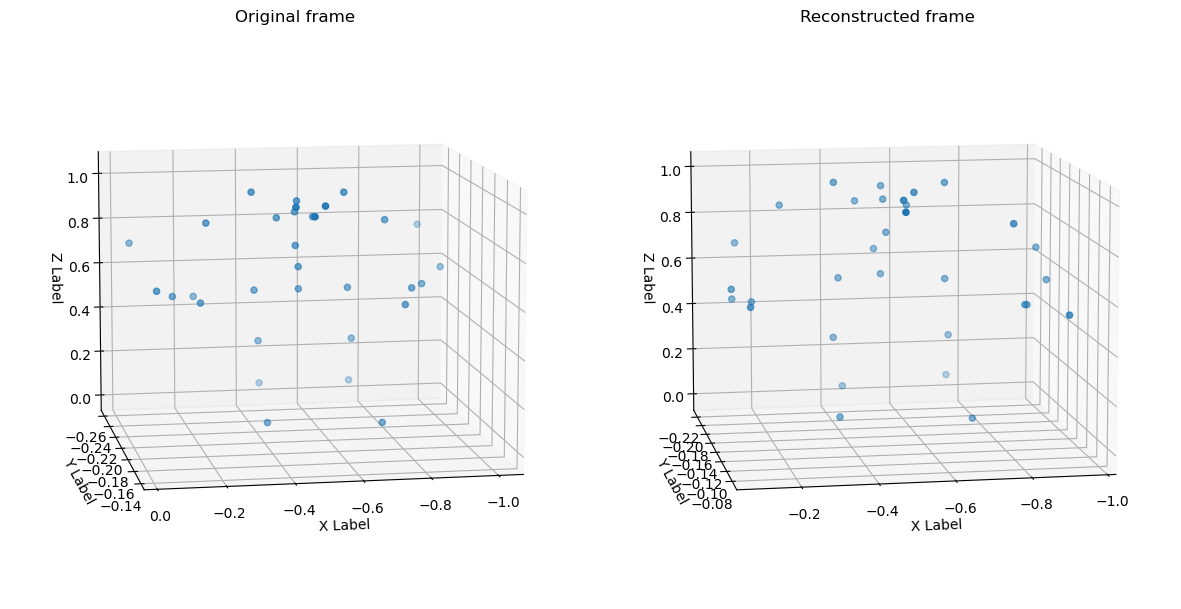

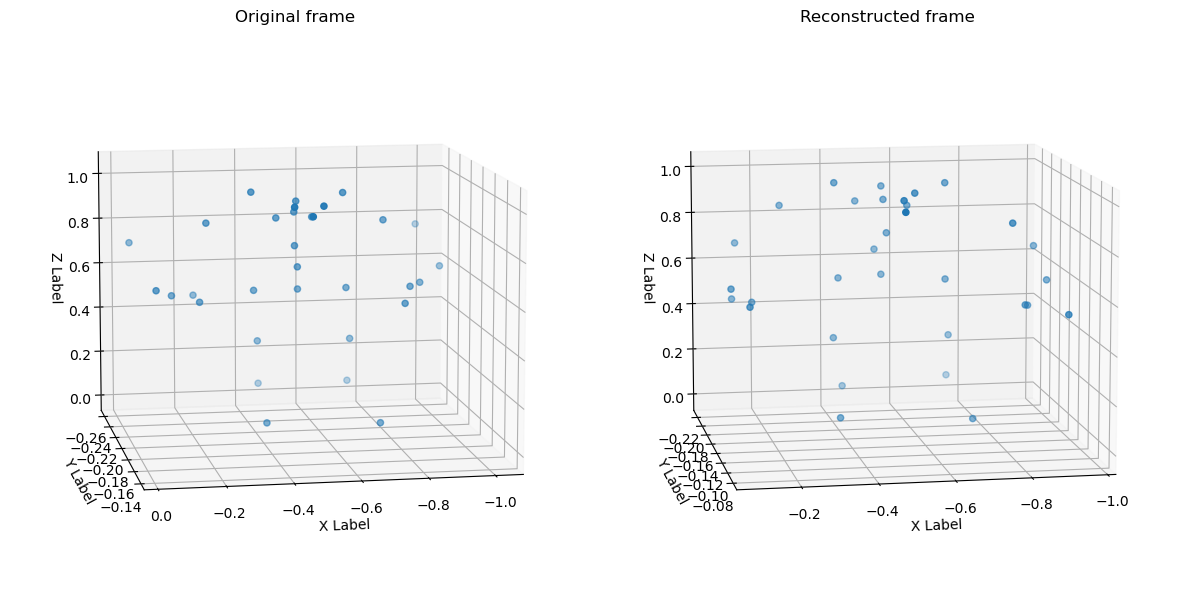

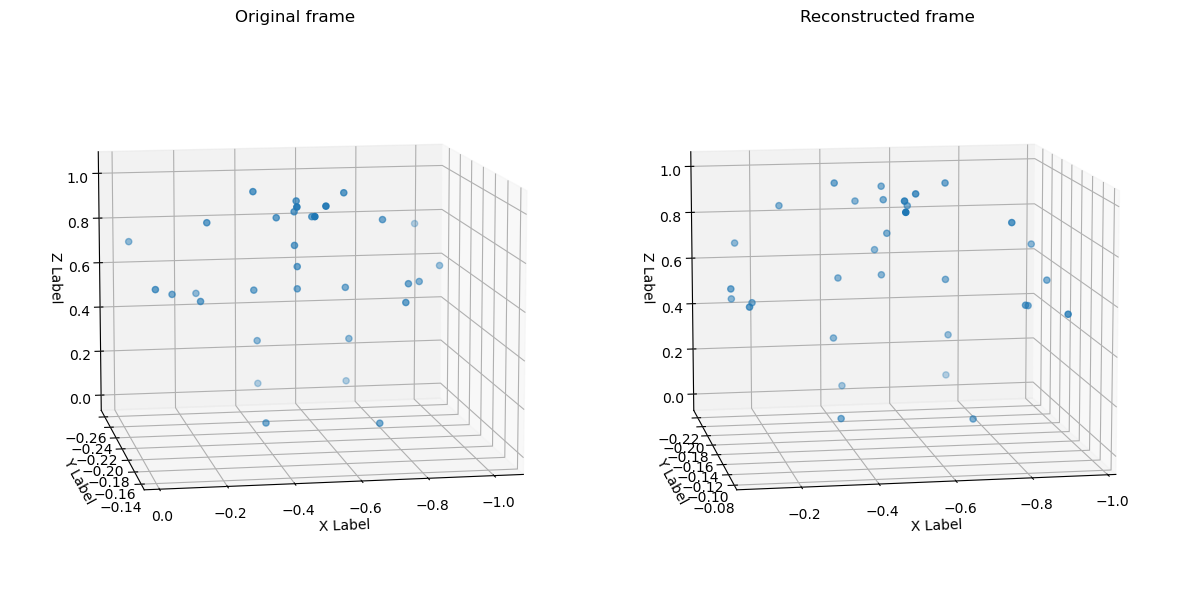

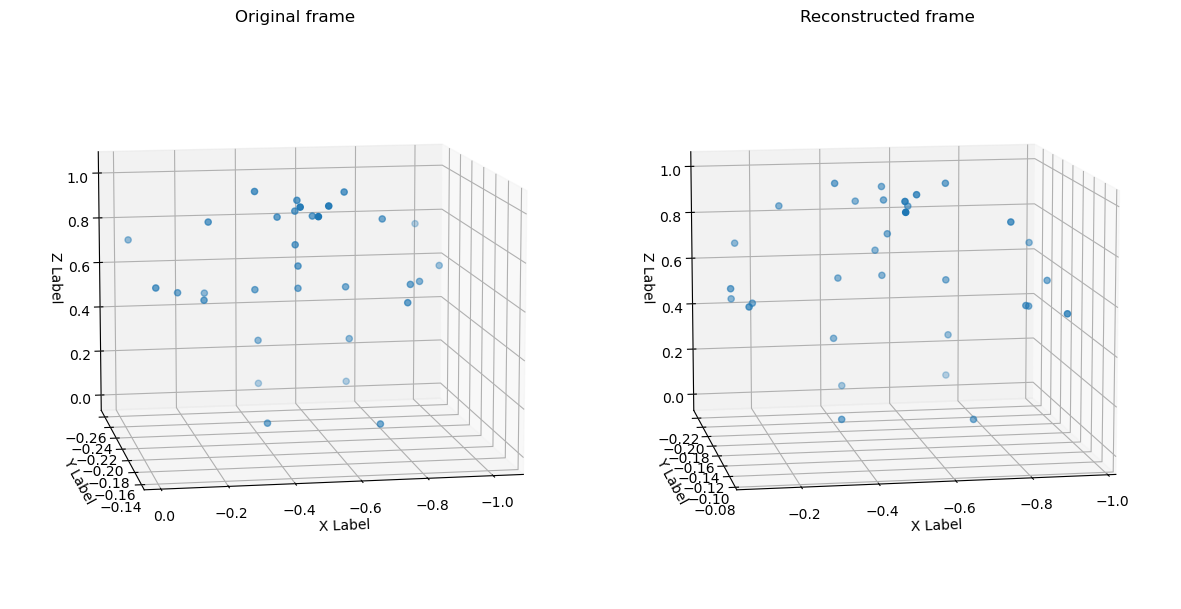

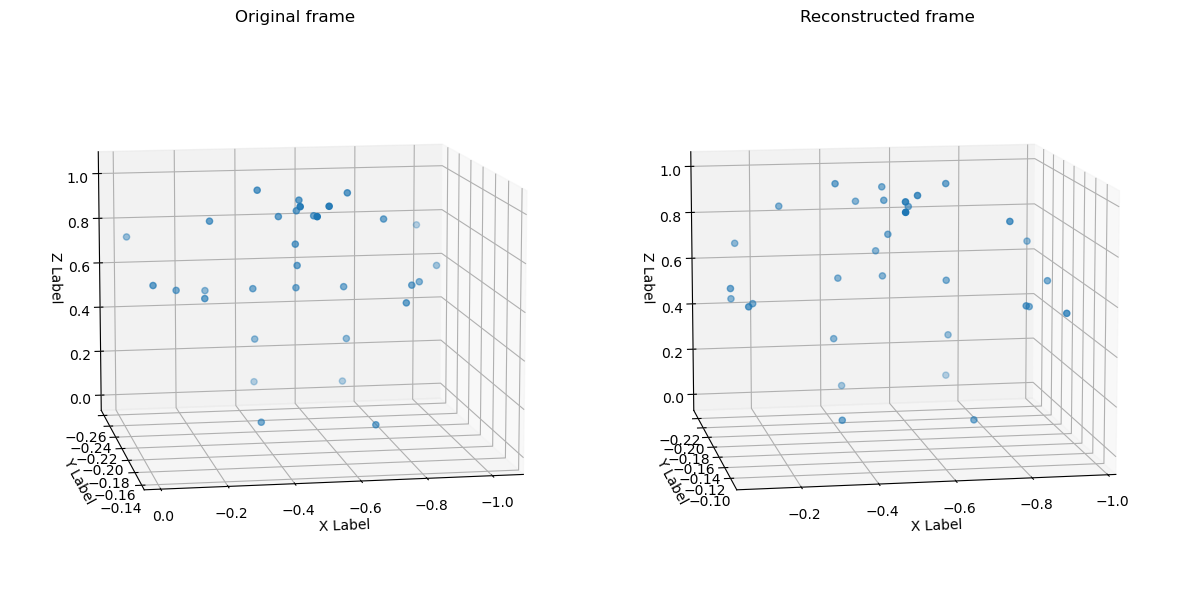

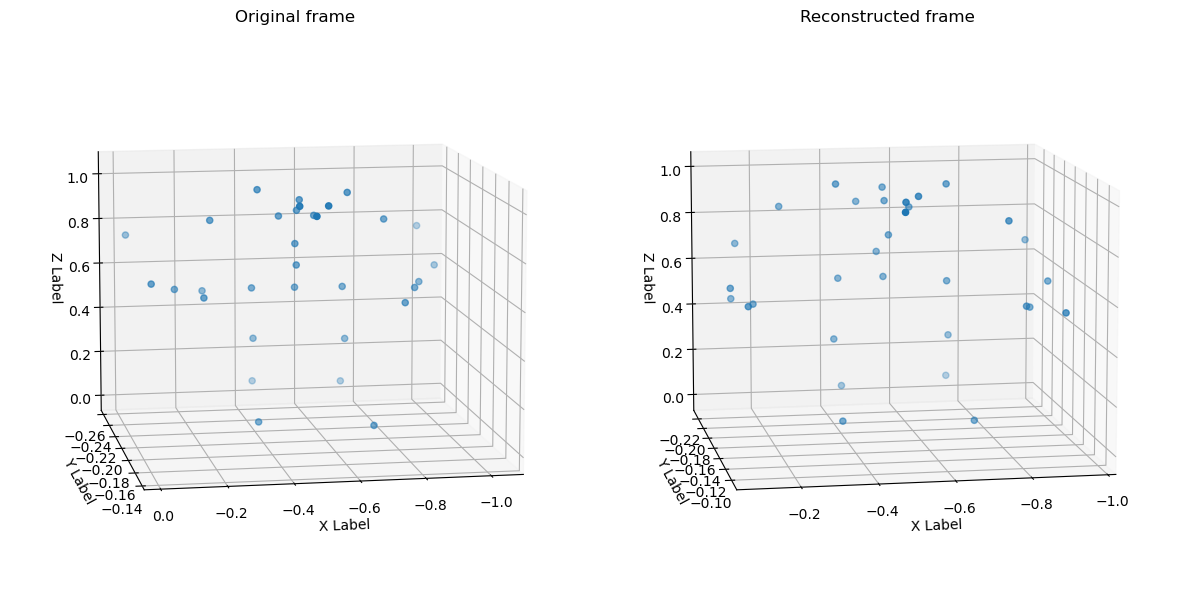

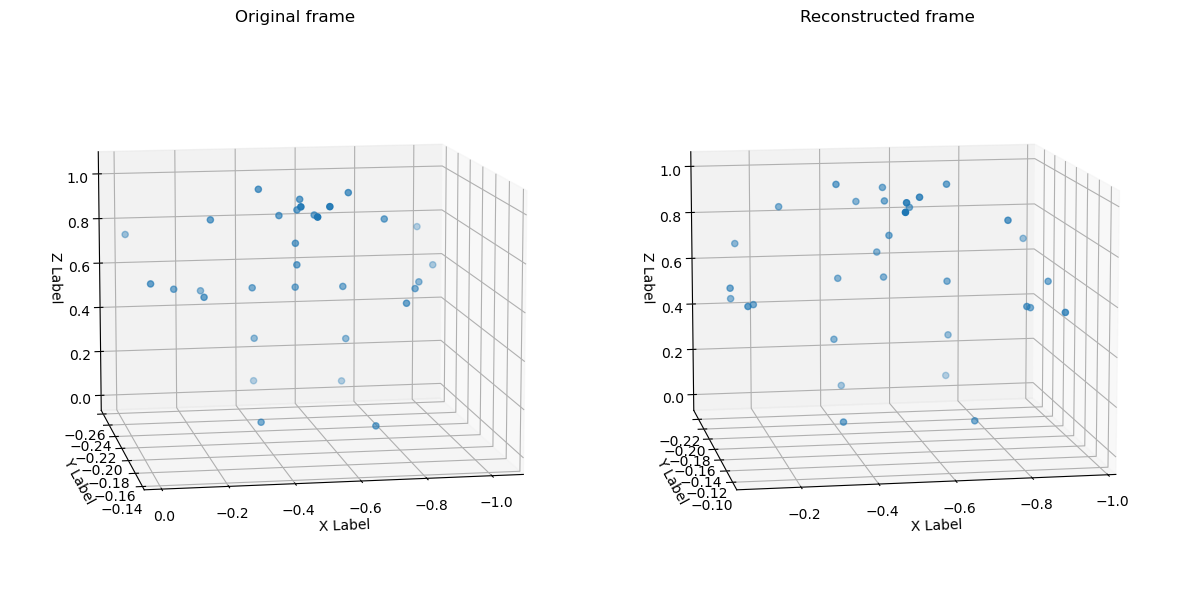

In [66]:
# Example

sk_data = load_data_sk(val_s.index[26], load=False)
sk_data_norm = normalize_data_sk(sk_data)

seq = sk_data_norm[10:60, :, :].reshape((50, -1))
seq_input = seq[np.newaxis, :]

code = encoder_rnn_load.predict(seq_input)
print(code.shape)
reco = decoder_rnn_load.predict(code).reshape((50, 96))

for time in range(20):
  t = time
  frame_input = seq[t, :].reshape((32, -1))
  frame_output = reco[t, :].reshape((32, -1))
  # print(frame_input.shape)
  # print(frame_output.shape)


  fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

  # First subplot (frame_input)
  ax1 = axes[0]
  ax1.scatter(frame_input[:, 0], frame_input[:, 1], frame_input[:, 2])
  ax1.set_xlabel('X Label')
  ax1.set_ylabel('Y Label')
  ax1.set_zlabel('Z Label')
  ax1.set_title('Original frame')
  ax1.view_init(elev=10, azim=80)

  # Second subplot (frame_output)
  ax2 = axes[1]
  ax2.scatter(frame_output[:, 0], frame_output[:, 1], frame_output[:, 2])
  ax2.set_xlabel('X Label')
  ax2.set_ylabel('Y Label')
  ax2.set_zlabel('Z Label')
  ax2.set_title('Reconstructed frame')
  ax2.view_init(elev=10, azim=80)

  plt.tight_layout()
  plt.show()
  print('\n', '\n')


In [67]:
### Benchmark function
def benchmark_rnn(code_size, latent_dim):
    print("Validation loss for code_size= ", code_size, 'and latent dimension ', latent_dim)
    encoder_rnn, decoder_rnn = RNN_autoencoder(time_length=50, latent_dim=225, code_size=125)
    
    inp_seq = tf.keras.Input((50, 96))
    code_rnn = encoder_rnn(inp_seq)
    reconstruction_seq = decoder_rnn(code_rnn)

    autoencoder_rnn = tf.keras.Model(inputs=inp_seq, outputs=reconstruction_seq)
    autoencoder_rnn.compile(optimizer="adamax", loss='mse')
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

    autoencoder_rnn.fit(dataset_train_s_autoencoder,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_s,
                    validation_data=dataset_val_s_autoencoder,
                    validation_steps=val_steps_s,
                    callbacks=[early_stop_callback], verbose=0)
    
    print('Validation loss =', autoencoder_rnn.evaluate(dataset_val_s_autoencoder,steps=val_steps_s))

In [70]:
code_size_list = [8,16,32,64,128]
latdim_list = [64,128,256]

for i in latdim_list:
    for j in code_size_list:
        benchmark_rnn(j,i)

Validation loss for code_size=  8 and latent dimension  64
4/4 [==============================] - 0s 71ms/step - loss: 0.0035
Validation loss = 0.0034587716218084097
Validation loss for code_size=  16 and latent dimension  64
4/4 [==============================] - 0s 74ms/step - loss: 0.0041
Validation loss = 0.004071204457432032
Validation loss for code_size=  32 and latent dimension  64
4/4 [==============================] - 0s 73ms/step - loss: 0.0035
Validation loss = 0.003485089633613825
Validation loss for code_size=  64 and latent dimension  64
4/4 [==============================] - 0s 75ms/step - loss: 0.0035
Validation loss = 0.003494629170745611
Validation loss for code_size=  128 and latent dimension  64
4/4 [==============================] - 0s 71ms/step - loss: 0.0035
Validation loss = 0.0034683814737945795
Validation loss for code_size=  8 and latent dimension  128
4/4 [==============================] - 0s 69ms/step - loss: 0.0044
Validation loss = 0.004433015361428261
Va

## CNN autoencoders

In [20]:
def CNN_autoencoder(img_shape, code_size):
    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(tf.keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(tf.keras.layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(tf.keras.layers.Dense(8 * 3 * 256, activation='elu'))
    decoder.add(tf.keras.layers.Reshape((8, 3, 256)))
    decoder.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder

input_shape = (128, 48, 1)
# print(input_shape)
encoder_cnn, decoder_cnn = CNN_autoencoder(input_shape, code_size=100)
# print(encoder_cnn.output_shape[1:])
# print(decoder_cnn.output_shape[1:])

encoder_cnn.summary()
decoder_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 48, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 6, 128)      

In [21]:
inp_cnn = tf.keras.Input(input_shape)
code_cnn = encoder_cnn(inp_cnn)
reconstruction_cnn = decoder_cnn(code_cnn)

autoencoder_cnn = tf.keras.Model(inputs=inp_cnn, outputs=reconstruction_cnn)

autoencoder_cnn.compile(optimizer="adamax", loss='mse')

In [38]:
# Train the model
num_epochs = 100

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=5)

autoencoder_cnn.fit(dataset_train_p_autoencoder,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_p,
                    validation_data=dataset_val_p_autoencoder,
                    validation_steps=val_steps_p,
                    callbacks=[early_stop_callback], verbose=3)



path_encoder_CNN = root_directory + '/encoder_CNN.h5'
path_decoder_CNN = root_directory + '/decoder_CNN.h5'

encoder_cnn.save(path_encoder_CNN)
decoder_cnn.save(path_decoder_CNN)

Epoch 1/100
Epoch 2/100


KeyboardInterrupt: 

In [33]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

1/1 [==============================] - 0s 101ms/step


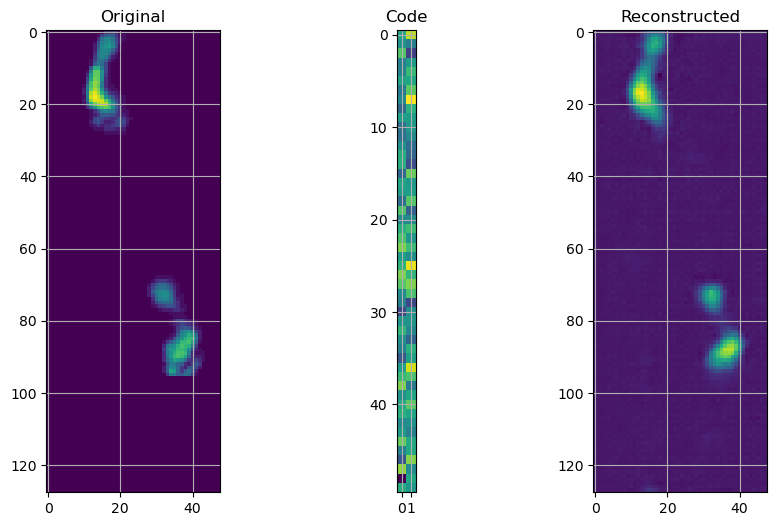

1/1 [==============================] - 0s 19ms/step


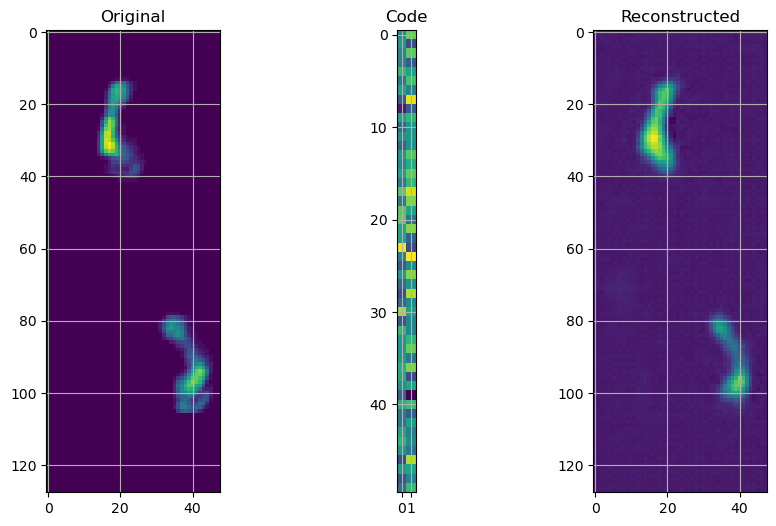

1/1 [==============================] - 0s 16ms/step


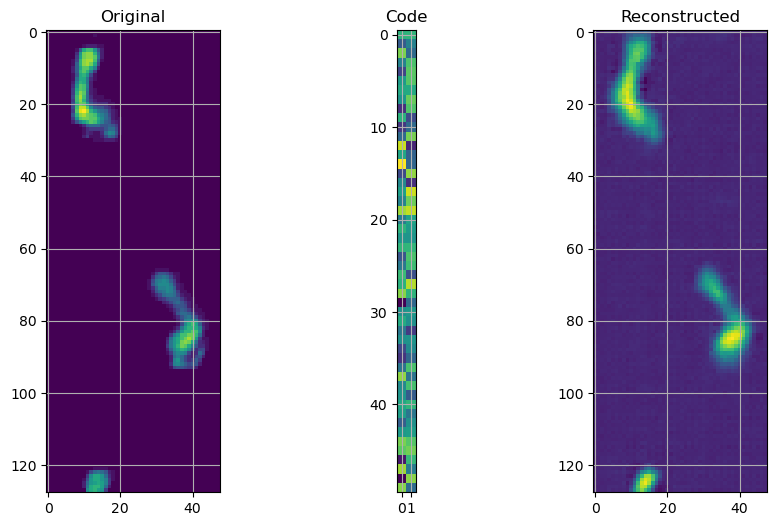

1/1 [==============================] - 0s 19ms/step


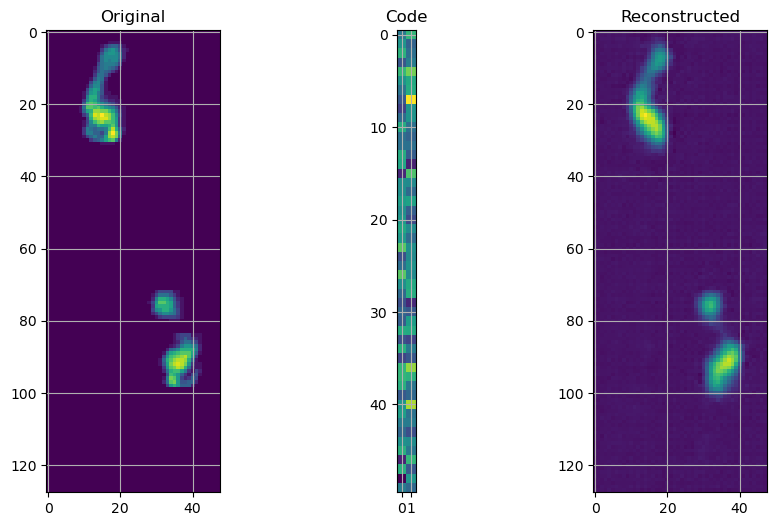

1/1 [==============================] - 0s 19ms/step


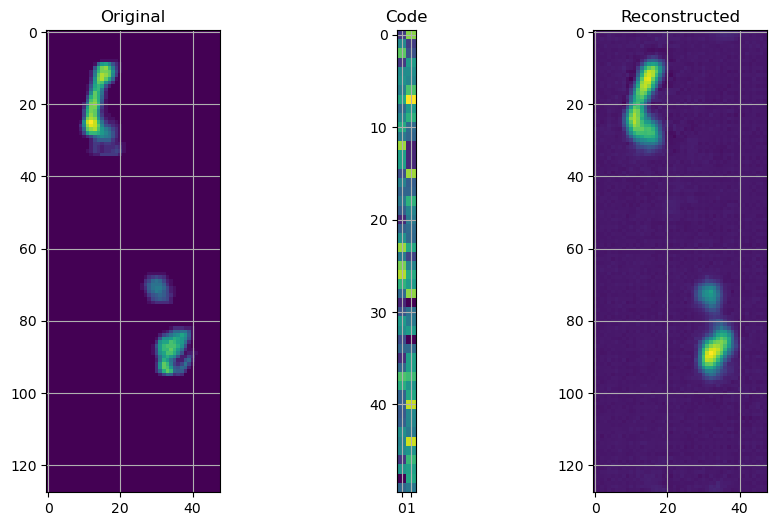

In [23]:
for i in np.arange(5):
  ps_data = load_data_ps(val_p.index[i], load=False)
  ps_data_norm = normalize_data_ps(ps_data)

  code = encoder_cnn.predict(ps_data_norm[np.newaxis, :])[0]
  reco = decoder_cnn.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title("Original")
  plt.imshow(ps_data_norm)

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  plt.imshow(reco)
  plt.show()

In [24]:
encoder_cnn_load = keras.models.load_model(path_encoder_CNN)
decoder_cnn_load = keras.models.load_model(path_decoder_CNN)

1/1 [==============================] - 0s 69ms/step


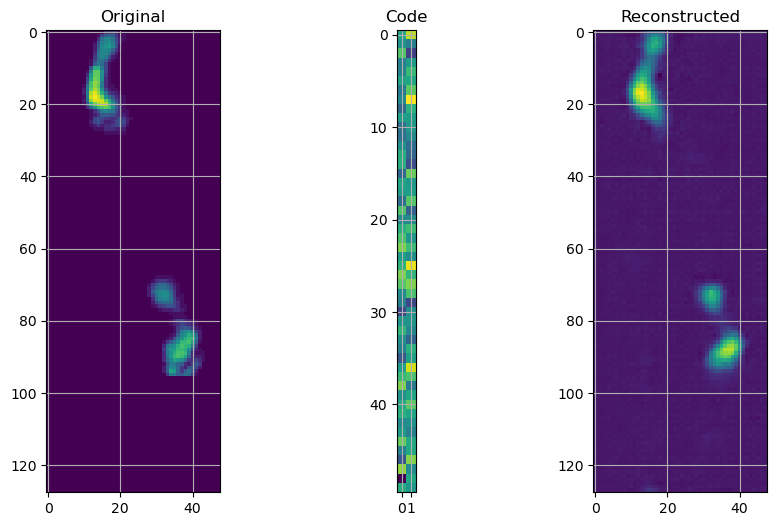

1/1 [==============================] - 0s 18ms/step


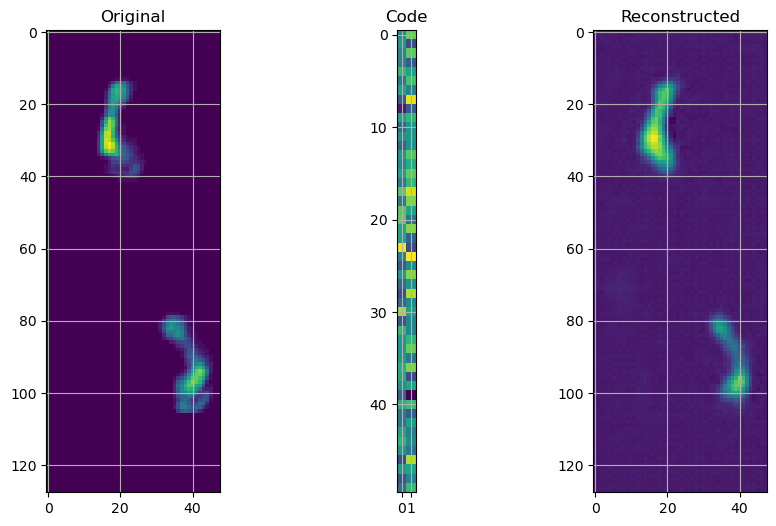

1/1 [==============================] - 0s 25ms/step


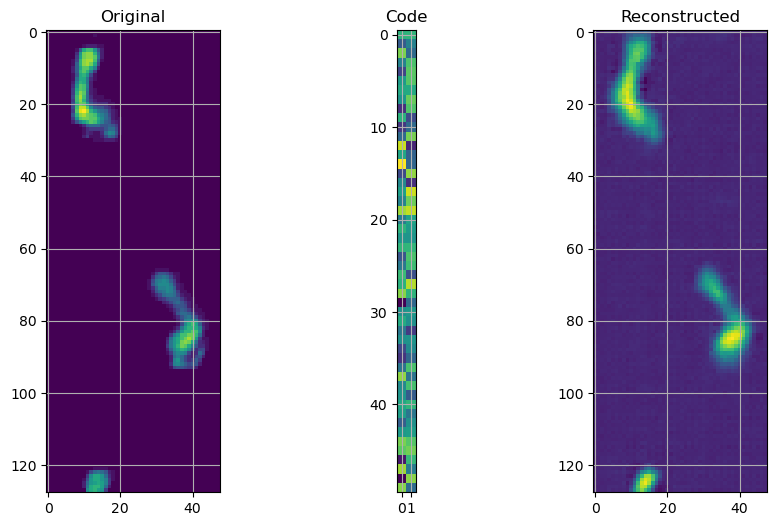

1/1 [==============================] - 0s 16ms/step


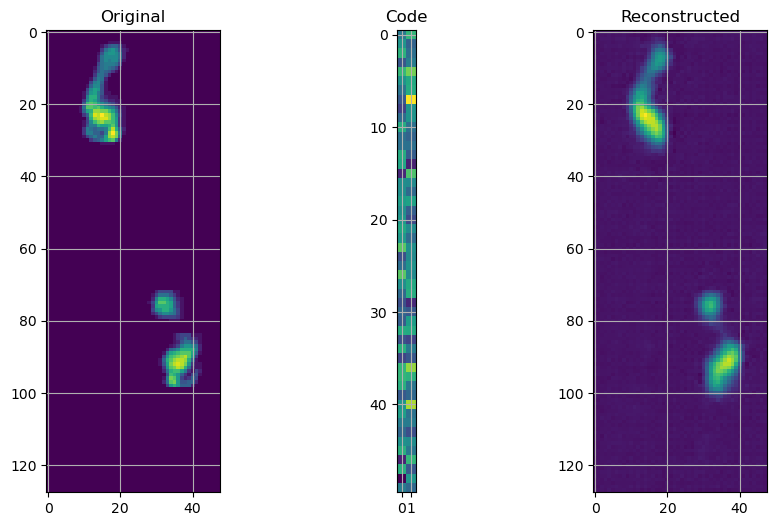

1/1 [==============================] - 0s 18ms/step


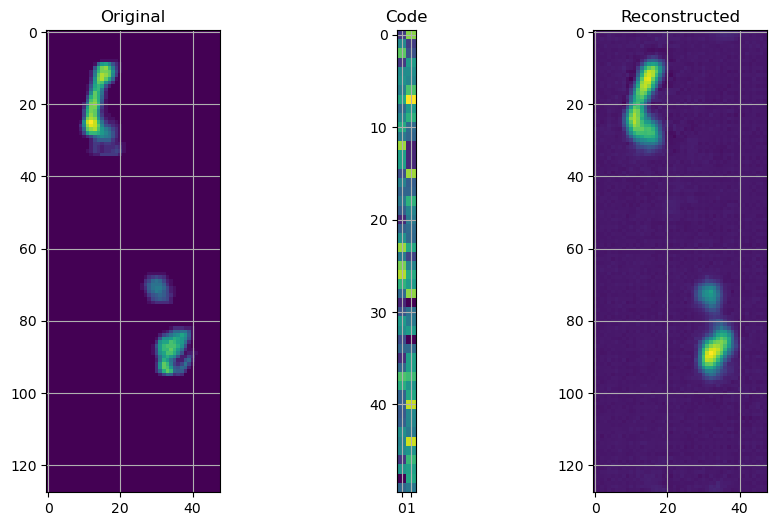

In [25]:
for i in np.arange(5):
  ps_data = load_data_ps(val_p.index[i], load=False)
  ps_data_norm = normalize_data_ps(ps_data)

  code = encoder_cnn_load.predict(ps_data_norm[np.newaxis, :])[0]
  reco = decoder_cnn_load.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title("Original")
  plt.imshow(ps_data_norm)

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  plt.imshow(reco)
  plt.show()

In [71]:
### Benchmark function

def benchmark_cnn(code_size, optimizer):
    print("Validation loss for code_size =", code_size, 'and optimizer', optimizer)
    encoder_cnn, decoder_cnn = CNN_autoencoder(input_shape, code_size=code_size)
    
    inp_cnn = tf.keras.Input(input_shape)
    code_cnn = encoder_cnn(inp_cnn)
    reconstruction_cnn = decoder_cnn(code_cnn)

    autoencoder_cnn = tf.keras.Model(inputs=inp_cnn, outputs=reconstruction_cnn)

    autoencoder_cnn.compile(optimizer=optimizer, loss='mse')
    
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

    autoencoder_cnn.fit(dataset_train_p_autoencoder,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_p,
                    validation_data=dataset_val_p_autoencoder,
                    validation_steps=val_steps_p,
                    callbacks=[early_stop_callback], verbose = 0)
    
    print('Validation loss = ', autoencoder_cnn.evaluate(dataset_val_p_autoencoder, steps=val_steps_p))

In [72]:
code_size_list = [8,16,32,64,128]
optimizer_list = ['adamax','adam','rmsprop','sgd']

for i in optimizer_list:
    for j in code_size_list:
        benchmark_cnn(j,i)

Validation loss for code_size = 8 and optimizer adamax
6/6 [==============================] - 0s 52ms/step - loss: 0.0042
Validation loss =  0.004201090428978205
Validation loss for code_size = 16 and optimizer adamax
6/6 [==============================] - 0s 53ms/step - loss: 0.0028
Validation loss =  0.0027628534007817507
Validation loss for code_size = 32 and optimizer adamax
6/6 [==============================] - 0s 55ms/step - loss: 0.0023
Validation loss =  0.0023403847590088844
Validation loss for code_size = 64 and optimizer adamax
6/6 [==============================] - 0s 55ms/step - loss: 0.0022
Validation loss =  0.002188123995438218
Validation loss for code_size = 128 and optimizer adamax
6/6 [==============================] - 0s 51ms/step - loss: 0.0020
Validation loss =  0.002015246544033289
Validation loss for code_size = 8 and optimizer adam
6/6 [==============================] - 0s 50ms/step - loss: 0.0044
Validation loss =  0.0044257063418626785
Validation loss for co